# Simple Microscope Simulation - Biological Cells

This notebook demonstrates simulating microscope imaging of multiple biological cells using the `simple_microscope` function.

## Overview

We create a 2D sample with ~100 biological cells:
- Uniformly distributed across the field of view (grid + jitter)
- Random cell and nucleus sizes
- Each cell has unique refractive index (clustered values)
- Size-dependent transparency: bigger cells are more transparent
- Projected to 2D transmission function for imaging using vmap

## Imports

In [1]:
import janssen as jns
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as cmo
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Rectangle

In [2]:
jns.__version__

'2025.10.4'

In [3]:
%load_ext autoreload
%autoreload 2

## Define Simulation Parameters

We create a sample with 4096x4096 pixels at 0.25 µm pixel size to contain many cells.

In [4]:
pixel_size = 0.25e-6  # 0.25 microns
num_pixels = 4096  # Large grid for many cells
wavelength = 633e-9  # 633 nm (HeNe laser)

# Cell parameters
num_cells = 100
min_cell_radius_um = 8  # Minimum cell radius in microns
max_cell_radius_um = (
    100  # Maximum cell radius in microns (4x larger than before)
)

# Convert to pixels
min_cell_radius_pixels = min_cell_radius_um * 1e-6 / pixel_size
max_cell_radius_pixels = max_cell_radius_um * 1e-6 / pixel_size

# Nucleus is typically 30-40% of cell radius
nucleus_ratio = 0.35

# Refractive indices (typical values for biological tissue)
n_medium = 1.337 + 0.0j  # Water

# Random seed for reproducibility
np.random.seed(42)

print(f"Pixel size: {pixel_size * 1e6:.2f} microns")
print(f"Grid size: {num_pixels} x {num_pixels} pixels")
print(
    f"Field of view: {pixel_size * num_pixels * 1e6:.0f} µm = {pixel_size * num_pixels * 1e3:.2f} mm"
)
print(f"Wavelength: {wavelength * 1e9:.0f} nm")
print(f"Number of cells: {num_cells}")
print(
    f"Cell radius range: {min_cell_radius_um}-{max_cell_radius_um} µm ({min_cell_radius_pixels:.0f}-{max_cell_radius_pixels:.0f} pixels)"
)

Pixel size: 0.25 microns
Grid size: 4096 x 4096 pixels
Field of view: 1024 µm = 1.02 mm
Wavelength: 633 nm
Number of cells: 100
Cell radius range: 8-100 µm (32-400 pixels)


## 1. Generate Random Cell Parameters

Create random positions, radii, and refractive indices for all cells using uniform grid distribution with jitter.

In [5]:
# Generate uniformly distributed cell positions using grid + jitter
grid_size = int(np.ceil(np.sqrt(num_cells)))  # e.g., 10x10 grid for 100 cells

# Cells can extend to edges and be cut off
grid_spacing_y = num_pixels / grid_size
grid_spacing_x = num_pixels / grid_size

grid_y, grid_x = np.meshgrid(
    np.linspace(
        grid_spacing_y / 2, num_pixels - grid_spacing_y / 2, grid_size
    ),
    np.linspace(
        grid_spacing_x / 2, num_pixels - grid_spacing_x / 2, grid_size
    ),
)
grid_centers = np.stack([grid_y.ravel(), grid_x.ravel()], axis=1)

# Randomly select num_cells positions from grid and add jitter
selected_indices = np.random.choice(
    len(grid_centers), num_cells, replace=False
)
cell_centers = grid_centers[selected_indices]

# Add jitter (up to 25% of grid spacing for more uniform look)
jitter_amount = 0.25 * min(grid_spacing_y, grid_spacing_x)
cell_centers_y = cell_centers[:, 0] + np.random.uniform(
    -jitter_amount, jitter_amount, num_cells
)
cell_centers_x = cell_centers[:, 1] + np.random.uniform(
    -jitter_amount, jitter_amount, num_cells
)

# Cell radii: uniform distribution between min and max
cell_radii_pixels = np.random.uniform(
    min_cell_radius_pixels, max_cell_radius_pixels, num_cells
)
nucleus_radii_pixels = cell_radii_pixels * nucleus_ratio

# Refractive index - unique for each cell, clustered values
# Bigger cells are more transparent (smaller contrast), smaller cells less transparent
radius_normalized = (cell_radii_pixels - min_cell_radius_pixels) / (
    max_cell_radius_pixels - min_cell_radius_pixels
)

# Cytoplasm refractive index (real part: 1.36-1.38 range)
# Smaller cells: higher contrast, bigger cells: lower contrast
base_n_cytoplasm_real = 1.355 + 0.015 * (
    1 - radius_normalized
)  # Inversely proportional to size
cytoplasm_n_real = base_n_cytoplasm_real + np.random.uniform(
    -0.002, 0.002, num_cells
)

# Cytoplasm absorption (imaginary part)
base_n_cytoplasm_imag = 0.0005 + 0.002 * (1 - radius_normalized)
cytoplasm_n_imag = base_n_cytoplasm_imag + np.random.uniform(
    -0.0002, 0.0002, num_cells
)
cytoplasm_n_imag = np.maximum(cytoplasm_n_imag, 0)

cytoplasm_n = cytoplasm_n_real + 1j * cytoplasm_n_imag

# Nucleus refractive index (higher than cytoplasm)
nucleus_n_real = (
    cytoplasm_n_real + 0.02 + np.random.uniform(-0.005, 0.005, num_cells)
)
nucleus_n_imag = cytoplasm_n_imag * 1.5 + np.random.uniform(
    -0.0003, 0.0003, num_cells
)
nucleus_n_imag = np.maximum(nucleus_n_imag, 0)

nucleus_n = nucleus_n_real + 1j * nucleus_n_imag

print(f"Generated {num_cells} cells with uniform distribution")
print(
    f"Grid: {grid_size}x{grid_size} = {grid_size**2} positions, selected {num_cells}"
)
print(f"Grid spacing: {grid_spacing_y:.0f} x {grid_spacing_x:.0f} pixels")
print(
    f"Center Y range: {cell_centers_y.min():.0f} to {cell_centers_y.max():.0f} pixels"
)
print(
    f"Center X range: {cell_centers_x.min():.0f} to {cell_centers_x.max():.0f} pixels"
)
print(
    f"Cell radius range: {cell_radii_pixels.min():.0f} to {cell_radii_pixels.max():.0f} pixels"
)
print(
    f"Nucleus radius range: {nucleus_radii_pixels.min():.0f} to {nucleus_radii_pixels.max():.0f} pixels"
)
print(
    f"Cytoplasm n (real) range: {cytoplasm_n_real.min():.4f} to {cytoplasm_n_real.max():.4f}"
)
print(
    f"Nucleus n (real) range: {nucleus_n_real.min():.4f} to {nucleus_n_real.max():.4f}"
)

Generated 100 cells with uniform distribution
Grid: 10x10 = 100 positions, selected 100
Grid spacing: 410 x 410 pixels
Center Y range: 122 to 3970 pixels
Center X range: 154 to 3988 pixels
Cell radius range: 34 to 393 pixels
Nucleus radius range: 12 to 138 pixels
Cytoplasm n (real) range: 1.3539 to 1.3712
Nucleus n (real) range: 1.3717 to 1.3946


## 2. Create 2D Sample with Cell Projections using vmap

For each cell, we compute the 2D projection (optical path length through a spherical cell with nucleus).
The path length at position (x,y) for a sphere of radius R is:
$L(x,y) = 2\sqrt{R^2 - x^2 - y^2}$ for $x^2 + y^2 < R^2$

In [6]:
# Create 2D sample with projected cells using vmap
# Create coordinate grids
y_coords = jnp.arange(num_pixels)
x_coords = jnp.arange(num_pixels)
yy, xx = jnp.meshgrid(y_coords, x_coords, indexing="ij")

# Wave number
k = 2 * jnp.pi / wavelength

# Convert cell parameters to JAX arrays
centers_y = jnp.array(cell_centers_y)
centers_x = jnp.array(cell_centers_x)
cell_radii = jnp.array(cell_radii_pixels)
nucleus_radii = jnp.array(nucleus_radii_pixels)
cytoplasm_n_arr = jnp.array(cytoplasm_n)
nucleus_n_arr = jnp.array(nucleus_n)


def compute_cell_transmission(cy, cx, cell_radius, nuc_radius, n_cyto, n_nuc):
    """Compute transmission contribution from a single cell with nucleus."""
    # Distance from cell center (in pixels)
    dist_sq = (yy - cy) ** 2 + (xx - cx) ** 2

    # Path length through cell (in meters)
    cell_path_pixels = 2 * jnp.sqrt(jnp.maximum(cell_radius**2 - dist_sq, 0))

    # Path length through nucleus (in meters)
    nucleus_path_pixels = 2 * jnp.sqrt(jnp.maximum(nuc_radius**2 - dist_sq, 0))

    # Cytoplasm path = total cell path minus nucleus path
    cytoplasm_path_pixels = cell_path_pixels - nucleus_path_pixels

    # Convert to meters
    cytoplasm_path_meters = cytoplasm_path_pixels * pixel_size
    nucleus_path_meters = nucleus_path_pixels * pixel_size

    # Phase and amplitude from cytoplasm and nucleus
    delta_n_cyto = n_cyto - n_medium
    delta_n_nuc = n_nuc - n_medium

    # Total transmission = exp(i*k*(delta_n_cyto*L_cyto + delta_n_nuc*L_nuc))
    cell_transmission = jnp.exp(
        1j
        * k
        * (
            delta_n_cyto * cytoplasm_path_meters
            + delta_n_nuc * nucleus_path_meters
        )
    )

    return cell_transmission


# vmap over all cells and multiply contributions together
all_transmissions = jax.vmap(compute_cell_transmission)(
    centers_y,
    centers_x,
    cell_radii,
    nucleus_radii,
    cytoplasm_n_arr,
    nucleus_n_arr,
)

# Product of all cell transmissions (shape: num_pixels x num_pixels)
sample_transmission = jnp.prod(all_transmissions, axis=0)

print(f"Sample created using vmap!")
print(
    f"Amplitude range: {jnp.abs(sample_transmission).min():.4f} to {jnp.abs(sample_transmission).max():.4f}"
)
print(
    f"Phase range: {jnp.angle(sample_transmission).min():.4f} to {jnp.angle(sample_transmission).max():.4f} rad"
)

Sample created using vmap!
Amplitude range: 0.0453 to 1.0000
Phase range: -3.1416 to 3.1416 rad


In [7]:
# Create sample function
cell_sample = jns.utils.make_sample_function(
    sample=sample_transmission,
    dx=pixel_size,
)

print(f"Sample shape: {cell_sample.sample.shape}")
print(f"Sample dx: {cell_sample.dx * 1e6:.2f} microns")

Sample shape: (4096, 4096)
Sample dx: 0.25 microns


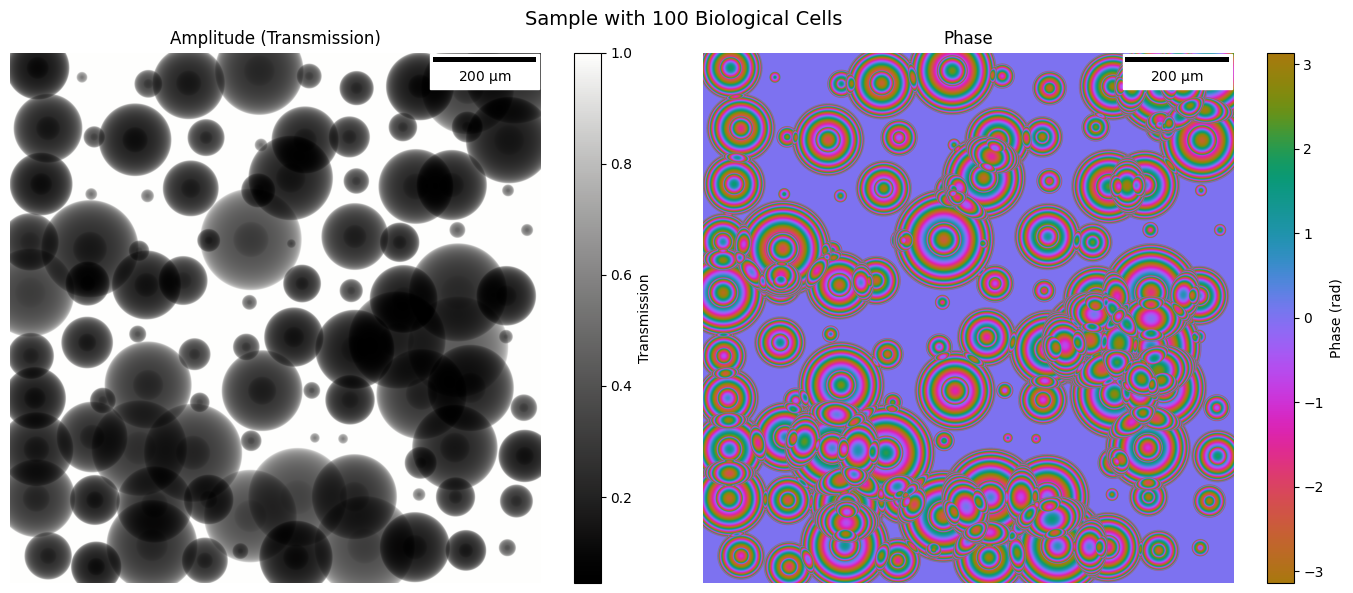

In [8]:
# Visualize the sample
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

amp = jnp.abs(cell_sample.sample)
phase = jnp.angle(cell_sample.sample)

# Amplitude
im0 = axes[0].imshow(amp, cmap=cmo.gray)
axes[0].set_title("Amplitude (Transmission)")
scalebar = ScaleBar(cell_sample.dx, "m", length_fraction=0.25, color="black")
axes[0].add_artist(scalebar)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], label="Transmission")

# Phase
im1 = axes[1].imshow(phase, cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi)
axes[1].set_title("Phase")
scalebar = ScaleBar(cell_sample.dx, "m", length_fraction=0.25, color="black")
axes[1].add_artist(scalebar)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], label="Phase (rad)")

plt.suptitle(f"Sample with {num_cells} Biological Cells", fontsize=14)
plt.tight_layout()
plt.show()

## 3. Create Illumination Wavefront

In [9]:
illumination_size = 512

lightwave = jns.models.plane_wave(
    wavelength=wavelength,
    dx=pixel_size,
    grid_size=(illumination_size, illumination_size),
    amplitude=1.0,
)

print(f"Illumination field shape: {lightwave.field.shape}")
print(f"Illumination wavelength: {lightwave.wavelength * 1e9:.0f} nm")
print(f"Illumination dx: {lightwave.dx * 1e6:.2f} microns")
print(f"Illumination FOV: {illumination_size * pixel_size * 1e6:.0f} microns")

Illumination field shape: (512, 512)
Illumination wavelength: 633 nm
Illumination dx: 0.25 microns
Illumination FOV: 128 microns


## 4. Set Microscope Parameters

In [10]:
# Microscope parameters
zoom_factor = 10.0  # 10x magnification
aperture_diameter = 1e-3  # 1 mm aperture
travel_distance = 0.15  # 150 mm to camera
detector_pixel_size = jnp.array(16e-6)  # 16 micron camera pixels

print(f"Zoom factor: {zoom_factor}x")
print(f"Aperture diameter: {aperture_diameter * 1e3:.1f} mm")
print(f"Travel distance: {travel_distance * 1e3:.0f} mm")
print(f"Detector pixel size: {detector_pixel_size * 1e6:.1f} µm")

Zoom factor: 10.0x
Aperture diameter: 1.0 mm
Travel distance: 150 mm
Detector pixel size: 16.0 µm


## 5. Step-by-Step Diffractogram Formation

Let's visualize each step in the formation of a diffractogram:
1. **Linear Interaction** - Light interacts with the sample
2. **Optical Zoom** - Magnification by the objective lens
3. **Circular Aperture** - Limits the numerical aperture
4. **Fraunhofer Propagation** - Far-field propagation to the camera

In [ ]:
# Cut sample at center for step-by-step visualization
center_pixel = num_pixels // 2
half_size = illumination_size // 2
sample_cut = cell_sample.sample[
    center_pixel - half_size : center_pixel + half_size,
    center_pixel - half_size : center_pixel + half_size,
]

sample_region = jns.utils.make_sample_function(
    sample=sample_cut,
    dx=pixel_size,
)

print(f"Sample region shape: {sample_region.sample.shape}")

In [ ]:
# Step 1: Linear Interaction - Light through sample
after_sample = jns.scopes.linear_interaction(
    sample=sample_region,
    light=lightwave,
)

print(f"After sample field shape: {after_sample.field.shape}")
print(f"After sample dx: {after_sample.dx * 1e6:.2f} microns")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(jnp.abs(sample_region.sample), cmap=cmo.gray)
axes[0].set_title("Sample Region")
scalebar = ScaleBar(sample_region.dx, "m", length_fraction=0.25, color="black")
axes[0].add_artist(scalebar)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.abs(after_sample.field) ** 2, cmap=cmo.gray)
axes[1].set_title("Field Intensity After Sample")
scalebar = ScaleBar(after_sample.dx, "m", length_fraction=0.25, color="black")
axes[1].add_artist(scalebar)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(
    jnp.angle(after_sample.field), cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi
)
axes[2].set_title("Field Phase After Sample")
scalebar = ScaleBar(after_sample.dx, "m", length_fraction=0.25, color="black")
axes[2].add_artist(scalebar)
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2])

plt.suptitle("Step 1: Linear Interaction", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Step 2: Optical Zoom - Magnification
zoomed_wave = jns.prop.optical_zoom(after_sample, zoom_factor)

print(f"Before zoom dx: {after_sample.dx * 1e6:.2f} microns")
print(f"After zoom dx: {zoomed_wave.dx * 1e6:.2f} microns")
print(f"Magnification achieved: {zoomed_wave.dx / after_sample.dx:.1f}x")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(jnp.abs(after_sample.field) ** 2, cmap=cmo.gray)
axes[0].set_title(f"Before Zoom (dx={after_sample.dx*1e6:.2f} µm)")
scalebar = ScaleBar(after_sample.dx, "m", length_fraction=0.25, color="black")
axes[0].add_artist(scalebar)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.abs(zoomed_wave.field) ** 2, cmap=cmo.gray)
axes[1].set_title(f"After Zoom (dx={zoomed_wave.dx*1e6:.2f} µm)")
scalebar = ScaleBar(zoomed_wave.dx, "m", length_fraction=0.25, color="black")
axes[1].add_artist(scalebar)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1])

plt.suptitle("Step 2: Optical Zoom (Magnification)", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Step 3: Circular Aperture - NA Limit
after_aperture = jns.optics.circular_aperture(
    zoomed_wave,
    diameter=aperture_diameter,
)

print(f"Aperture diameter: {aperture_diameter * 1e3:.1f} mm")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(jnp.abs(zoomed_wave.field) ** 2, cmap=cmo.gray)
axes[0].set_title("Before Aperture")
scalebar = ScaleBar(zoomed_wave.dx, "m", length_fraction=0.25, color="black")
axes[0].add_artist(scalebar)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.abs(after_aperture.field) ** 2, cmap=cmo.gray)
axes[1].set_title("After Circular Aperture")
scalebar = ScaleBar(
    after_aperture.dx, "m", length_fraction=0.25, color="black"
)
axes[1].add_artist(scalebar)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1])

plt.suptitle("Step 3: Circular Aperture", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Step 4: Fraunhofer Propagation - To Camera Plane
at_camera = jns.prop.fraunhofer_prop_scaled(
    after_aperture, travel_distance, output_dx=detector_pixel_size
)

print(f"Propagation distance: {travel_distance * 1e3:.0f} mm")
print(f"Camera plane dx: {at_camera.dx * 1e6:.2f} microns")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(
    jns.optics.field_intensity(at_camera.field), cmap=cmo.haline
)
axes[0].set_title("Intensity at Camera (Linear)")
scalebar = ScaleBar(at_camera.dx, "m", length_fraction=0.25, color="black")
axes[0].add_artist(scalebar)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(
    jnp.log10(1 + jns.optics.field_intensity(at_camera.field)), cmap=cmo.haline
)
axes[1].set_title("Intensity at Camera (Log)")
scalebar = ScaleBar(at_camera.dx, "m", length_fraction=0.25, color="black")
axes[1].add_artist(scalebar)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(
    jnp.angle(at_camera.field), cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi
)
axes[2].set_title("Phase at Camera")
scalebar = ScaleBar(at_camera.dx, "m", length_fraction=0.25, color="black")
axes[2].add_artist(scalebar)
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2])

plt.suptitle("Step 4: Fraunhofer Propagation to Camera", fontsize=14)
plt.tight_layout()
plt.show()

## 6. Compare with simple_diffractogram

Verify that the step-by-step approach matches the `simple_diffractogram` function.

In [ ]:
# Generate single diffractogram using the combined function
diffractogram = jns.scopes.simple_diffractogram(
    sample_cut=sample_region,
    lightwave=lightwave,
    zoom_factor=zoom_factor,
    aperture_diameter=aperture_diameter,
    travel_distance=travel_distance,
    camera_pixel_size=detector_pixel_size,
)

print(f"Diffractogram shape: {diffractogram.image.shape}")
print(f"Diffractogram dx: {diffractogram.dx * 1e6:.2f} µm")

In [ ]:
# Compare manual pipeline with simple_diffractogram
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Manual pipeline result
im0 = axes[0].imshow(
    jns.optics.field_intensity(at_camera.field), cmap=cmo.haline
)
axes[0].set_title("Manual Pipeline (Step by Step)")
scalebar = ScaleBar(at_camera.dx, "m", length_fraction=0.25, color="black")
axes[0].add_artist(scalebar)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0])

# Combined function result
im1 = axes[1].imshow(diffractogram.image, cmap=cmo.haline)
axes[1].set_title("simple_diffractogram Result")
scalebar = ScaleBar(diffractogram.dx, "m", length_fraction=0.25, color="black")
axes[1].add_artist(scalebar)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

# Verify they match
print(
    f"Max difference: {jnp.max(jnp.abs(jns.optics.field_intensity(at_camera.field) - diffractogram.image)):.2e}"
)

## 7. Full Microscope Simulation - Scanning

Create scan positions and run the full microscope simulation.

In [13]:
# Create scan positions centered on a region with cells
scan_step = 15e-6  # 15 micron step size (same as Spheres)
scan_pixel = scan_step / cell_sample.dx

# Center of the sample
scope_center = jnp.array(
    [num_pixels // 2, num_pixels // 2]
)  # (x, y) in pixels

num_scan_x = 20
num_scan_y = 20

xx, yy = jnp.meshgrid(
    jnp.arange(num_scan_x) * scan_pixel - (num_scan_x - 1) * scan_pixel / 2,
    jnp.arange(num_scan_y) * scan_pixel - (num_scan_y - 1) * scan_pixel / 2,
)
x_positions = xx + scope_center[0]
y_positions = yy + scope_center[1]
positions = jnp.stack([x_positions.ravel(), y_positions.ravel()], axis=1)

print(f"Scan step: {scan_step * 1e6:.0f} µm ({scan_pixel:.1f} pixels)")
print(f"Number of scan positions: {len(positions)}")
print(f"Scan grid: {num_scan_x} x {num_scan_y}")
print(
    f"Total scan area: {(num_scan_x-1) * scan_step * 1e6:.0f} x {(num_scan_y-1) * scan_step * 1e6:.0f} µm"
)

Scan step: 15 µm (60.0 pixels)
Number of scan positions: 400
Scan grid: 20 x 20
Total scan area: 285 x 285 µm


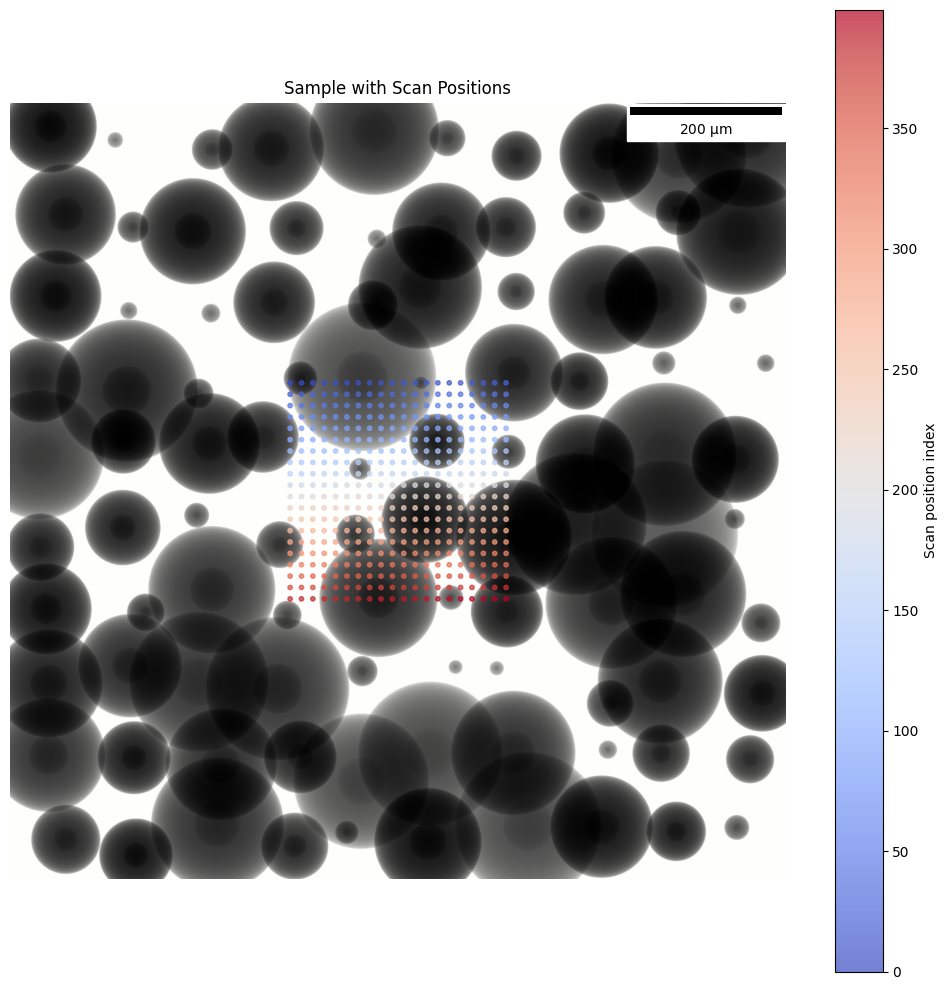

In [14]:
# Visualize scan positions on sample
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

im = ax.imshow(jnp.abs(cell_sample.sample), cmap=cmo.gray)
ax.set_title("Sample with Scan Positions")
scalebar = ScaleBar(cell_sample.dx, "m", length_fraction=0.25, color="black")
ax.add_artist(scalebar)

# Add scan positions as colored dots
scatter = ax.scatter(
    positions[:, 0],
    positions[:, 1],
    c=jnp.arange(len(positions)),
    cmap="coolwarm",
    s=10,
    alpha=0.7,
    marker="o",
)
plt.colorbar(scatter, ax=ax, label="Scan position index")
ax.axis("off")

plt.tight_layout()
plt.show()

In [15]:
# Run simple_microscope with all scan positions
positions_meters = positions * cell_sample.dx

microscope_data = jns.scopes.simple_microscope(
    sample=cell_sample,
    positions=positions_meters,
    lightwave=lightwave,
    zoom_factor=zoom_factor,
    aperture_diameter=aperture_diameter,
    travel_distance=travel_distance,
    camera_pixel_size=detector_pixel_size,
)

print(f"Microscope data shape: {microscope_data.image_data.shape}")
print(f"Number of diffractograms: {microscope_data.image_data.shape[0]}")
print(f"Diffractogram size: {microscope_data.image_data.shape[1:]}")
print(f"Camera pixel size: {microscope_data.dx * 1e6:.2f} µm")

Microscope data shape: (400, 512, 512)
Number of diffractograms: 400
Diffractogram size: (512, 512)
Camera pixel size: 16.00 µm


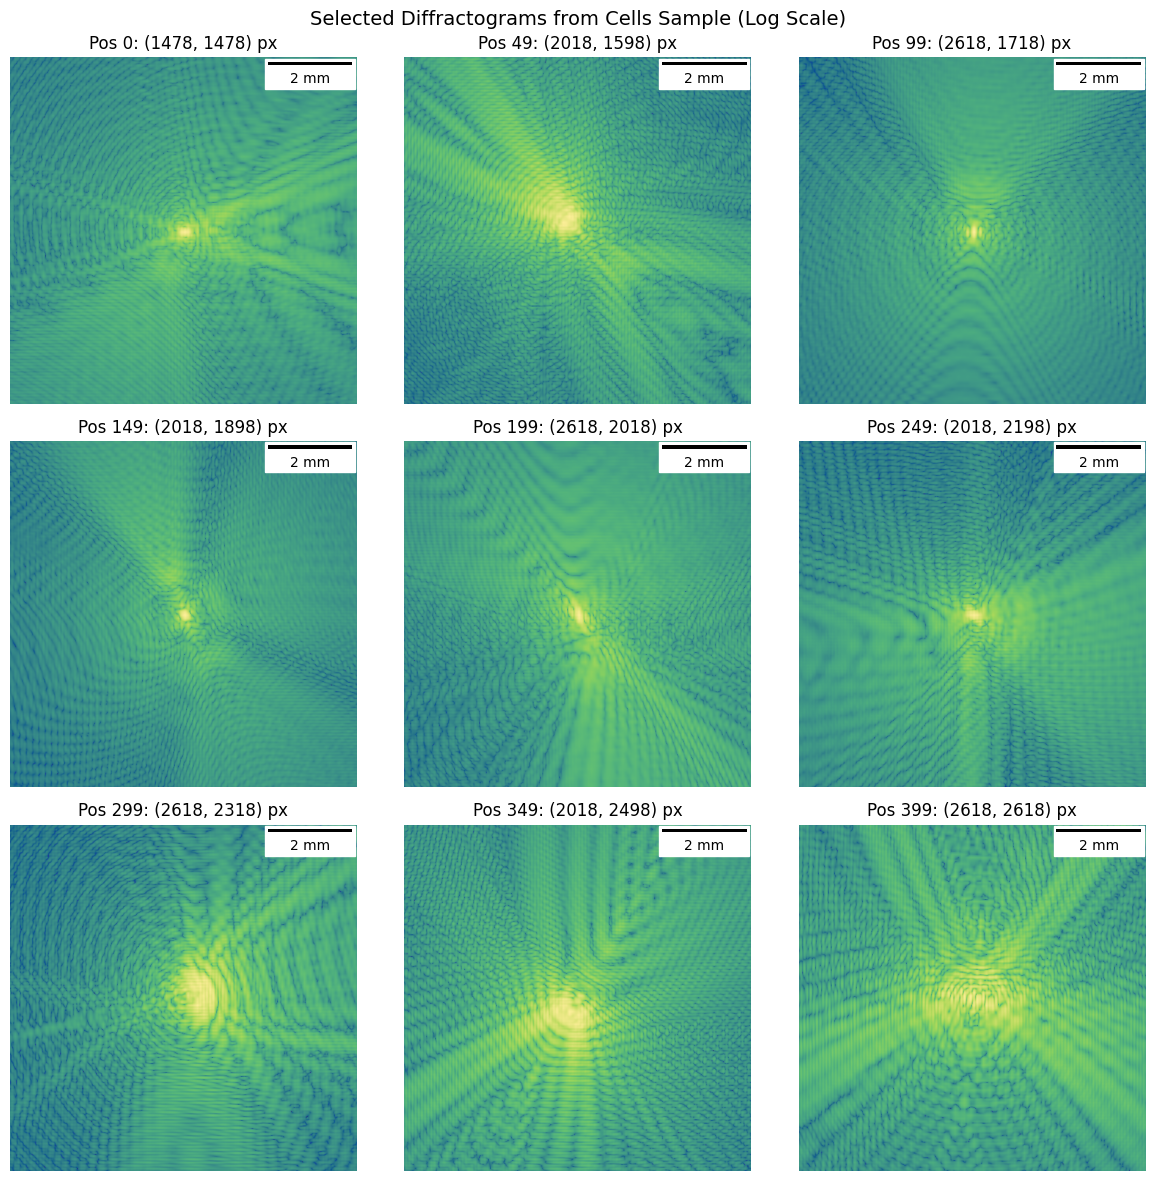

In [16]:
# Visualize a subset of diffractograms (9 evenly spaced)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

indices = jnp.linspace(0, len(positions) - 1, 9).astype(int)

for i, ax in enumerate(axes.flat):
    idx = int(indices[i])
    im = ax.imshow(
        jnp.log10(microscope_data.image_data[idx] + 1e-10), cmap=cmo.haline
    )
    pos = positions[idx]
    ax.set_title(f"Pos {idx}: ({pos[0]:.0f}, {pos[1]:.0f}) px")
    scalebar = ScaleBar(
        microscope_data.dx, "m", length_fraction=0.25, color="black"
    )
    ax.add_artist(scalebar)
    ax.axis("off")

plt.suptitle(
    "Selected Diffractograms from Cells Sample (Log Scale)", fontsize=14
)
plt.tight_layout()
plt.show()

## 8. Create Two-Panel Video

Create a video showing the sample with current scan position and the corresponding diffractogram.

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create figure with two panels
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Sample with current position marker
amp = jnp.abs(cell_sample.sample)
im_sample = axes[0].imshow(amp, cmap=cmo.gray)
axes[0].set_title("Sample with Scan Position")
scalebar_sample = ScaleBar(
    cell_sample.dx, "m", length_fraction=0.25, color="black"
)
axes[0].add_artist(scalebar_sample)
axes[0].axis("off")

# Position marker (red dot)
(position_marker,) = axes[0].plot([], [], "ro", markersize=10)

# Panel 2: Diffractogram
im_diffract = axes[1].imshow(
    jnp.log10(microscope_data.image_data[0] + 1e-10), cmap=cmo.haline
)
axes[1].set_title("Diffractogram (Log Scale)")
scalebar_diffract = ScaleBar(
    microscope_data.dx, "m", length_fraction=0.25, color="black"
)
axes[1].add_artist(scalebar_diffract)
axes[1].axis("off")
cbar = plt.colorbar(im_diffract, ax=axes[1], label="Log₁₀(Intensity)")

plt.tight_layout()


def init():
    position_marker.set_data([], [])
    return [im_diffract, position_marker]


def update(frame):
    # Update position marker
    pos = positions[frame]
    position_marker.set_data([pos[0]], [pos[1]])

    # Update diffractogram
    diffract_data = jnp.log10(microscope_data.image_data[frame] + 1e-10)
    im_diffract.set_array(diffract_data)

    # Update title with position info
    axes[0].set_title(
        f"Sample with Scan Position ({frame+1}/{len(positions)})"
    )

    return [im_diffract, position_marker]


# Create animation at 5 fps (200ms per frame)
anim = FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    blit=False,
    interval=200,
)

# Display animation
plt.close(fig)
HTML(anim.to_jshtml())

Animation size has reached 21269673 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


In [ ]:
# Save the animation as MP4 video
anim.save("cells_microscope_scan.mp4", writer="ffmpeg", fps=5, dpi=150)
print("Video saved as 'cells_microscope_scan.mp4'")